# Gaussian Mixture Model (GMM): Model Selection


In this notebook we investigate the model selection in GMM. It generally involves selection optimal an optimal value for $k$ and the covariance type for training GMM.

More specifically, we perform the following two tasks.

- Task 1: Selecting the Optimal Number of Clusters $k$
- Task 2: Model Selection: Finding Optimal $k$ and Covariance Type

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

## Synthetic Dataset

We will use Scikit-Learn's "make_blobs" function to generate **isotropic Gaussian blobs** for clustering. 

This function provides greater control regarding the centers and standard deviations of each cluster.

In [2]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

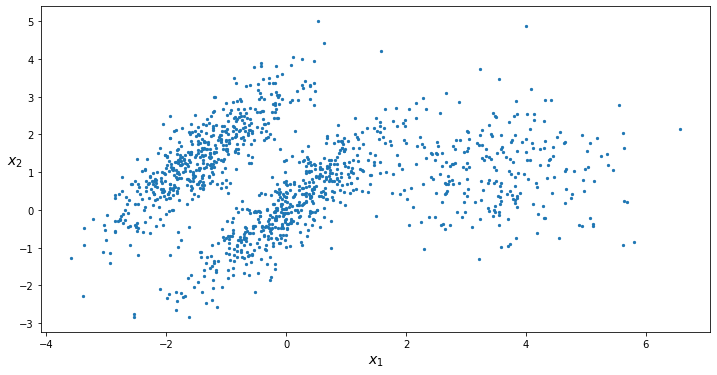

In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap='autumn')
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(12, 6))
plot_clusters(X)
plt.show()

## GMM

The dataset contain three clusters.

Let's train GMM with three clusters. 

In [4]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

## Plot the Clusters & Density Regions

We use the following functions to show the cluster means, the decision boundaries (using dashed lines), and the density contours of the GMM model.

We also show the density regions.

In [5]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        

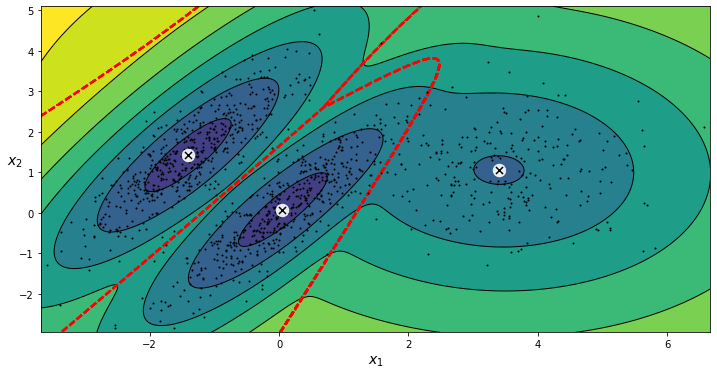

In [6]:
plt.figure(figsize=(12, 6))

plot_gaussian_mixture(gm, X)

plt.show()

## Task 1: Selecting the Optimal Number of Clusters


With K-Means, we could use the inertia or the silhouette score to select the appropriate number of clusters. But with Gaussian mixtures, it is not possible to use these metrics because they are not reliable when the clusters are **not spherical or have different sizes**. 

Instead, we can try to find the model that minimizes a **theoretical information criterion**, such as the Bayesian information criterion (BIC) or the Akaike information criterion (AIC).

AIC and BIC are both **penalized-likelihood** criteria.

        AIC is an estimate of a constant plus the relative distance between the unknown true likelihood function of the data and the fitted likelihood function of the model. So, a lower AIC means a model is considered to be closer to the truth. 

        BIC is an estimate of a function of the posterior probability of a model being true, under a certain Bayesian setup. So, a lower BIC means that a model is considered to be more likely to be the true model. 


Despite various subtle theoretical differences, their only difference in practice is the size of the penalty.
- BIC penalizes model complexity more heavily. The only way they should disagree is when AIC chooses a larger model than BIC.

In general, it might be best to use AIC and BIC together in model selection. For example, in selecting the number of latent classes in a model, if BIC points to a three-class model and AIC points to a five-class model, it makes sense to select from models with 3, 4 and 5 latent classes. 


### Formulas for Computing BIC and AIC


$BIC = log(n)p - 2log(\hat L)$

$AIC = 2p - 1 log (\hat L)$


- $n$ is the number of instances.
- $p$ is the number of parameters learned by the model.
- $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both the BIC and the AIC penalize models that have more parameters to learn (e.g., more clusters) and reward models that fit the data well (i.e., models that give a high likelihood to the observed data). 

They often end up selecting the same model. 

When they differ, the model selected by the BIC tends to be simpler (fewer parameters) than the one selected by the AIC, but tends to not fit the data quite as well (this is especially true for larger datasets).

In [7]:
# print("BIC: ", gm.bic(X))
# print("AIC: ", gm.aic(X))

## Manual Computation of BIC and AIC

In [8]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2

n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance

# "ccore" method computes the per-sample average log-likelihood of the given data X
max_log_likelihood = gm.score(X) * len(X) # log(L^)

# BIC and AIC
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

## Train GMM with Various Values of $k$ and Measure their BIC & AIC

In [9]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [10]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

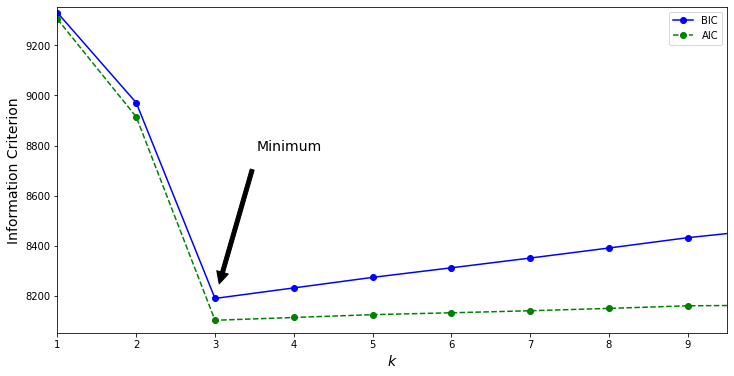

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()

plt.show()

## Task 1: Observation


We see that both the BIC and the AIC are lowest when $k = 3$.

Thus, it is most likely the best choice, which is indeed the case. The synthetic dataset that we used for training contains three clusters.




## Task 2: Model Selection: Finding Optimal $k$ and Covariance Type

We can find the best combination of values for both the number of clusters and the covariance_type hyperparameter.

In [12]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type
    
print("\nOptimal k: ", best_k)
print("\nOptimal Covariance Type: ", best_covariance_type)


Optimal k:  3

Optimal Covariance Type:  full
